### Linear Regression

- Normality: A normal distribution on the residual plot across the line of best fit
- Homoskedasticity: A constant line representing the spread of the points on the residual plot. If fulfilled, the assumption states that linear regression is a good approach for analyzing this data. If not, then another algorithim would be a better approach. 

Evalulating Linear Regression Models
- Mean Absolute Error (MAE): The sum of the values above and below the line of best fit and dividing by the number of values. 
($\sum_{i=1}|y_i - \hat{y_i}|$)/n$
- Mean Squared Error (MSE): Similar to MAE, but the instead of taking the absolute value, you square the expression. ($\sum_{i=1}(y_i - \hat{y_i})^2)/n$
- Root Mean Squared Error (RSME): Allows you to find the exact number that you are off from the prediction. $\sqrt{(\sum_{i=1}(y_i - \hat{y_i})^2)/n}$
- Coefficient of Determination ($R^2): 1 - sum of the squared residuals over the total sum of squares. Ideally, you would want $R^2$ to be as close to 0 as possible. $1-((\sum_{i=1}(y_i - \hat{y_i})^2)/n)/((\sum_{i=1}(y_i - \bar{y_i})^2)/n)$

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

### Dataset 

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Donated by P. Savicky Institute of Computer Science, AS of CR Czech Republic savicky '@' cs.cas.cz

Source: Data Source :http://data.seoul.go.kr/
SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr

In [ ]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)
# Dropping these columns from the dataset
df

In [ ]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis =1)

In [ ]:
df.head()

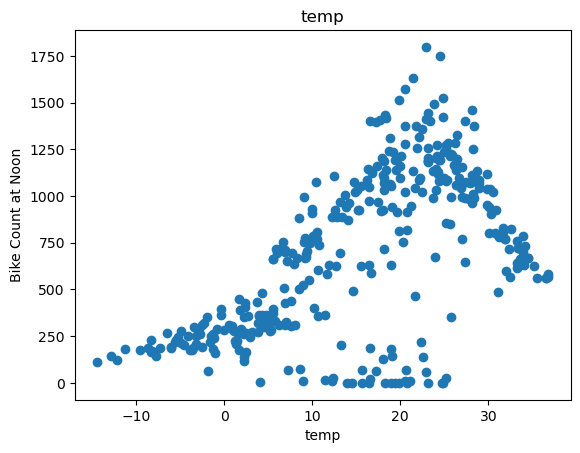

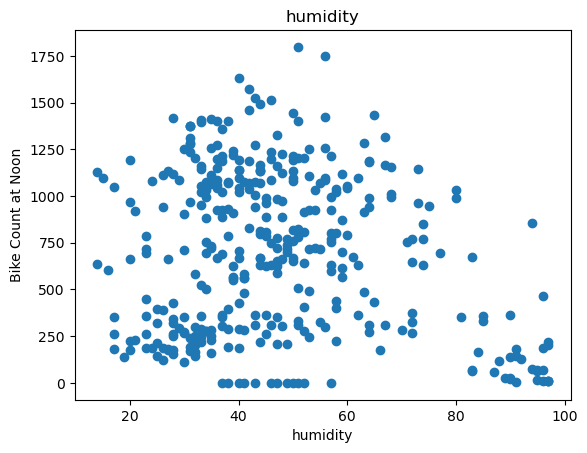

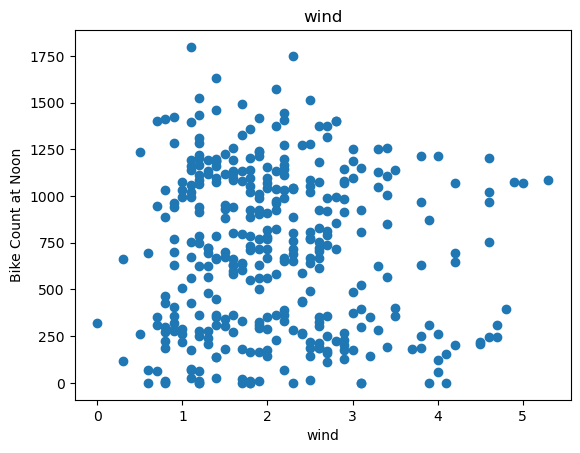

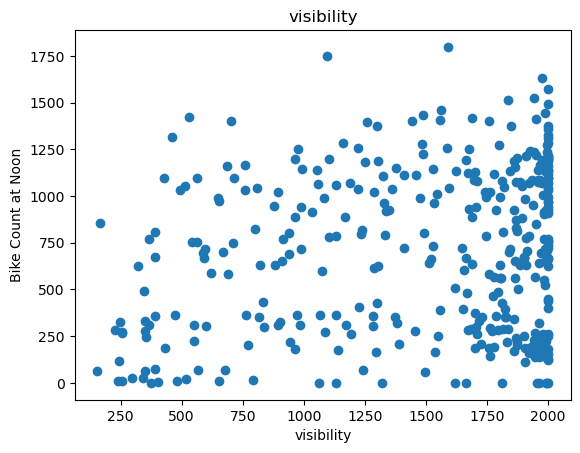

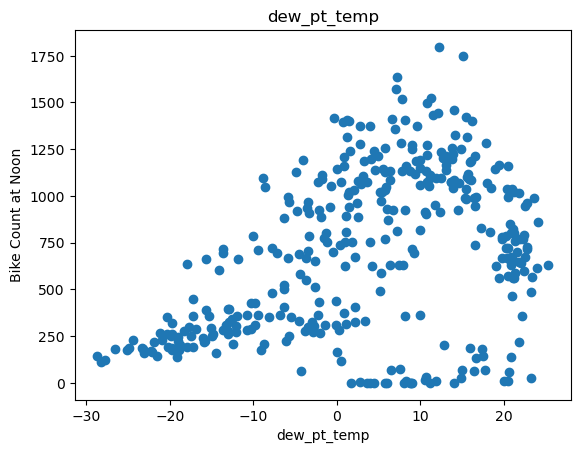

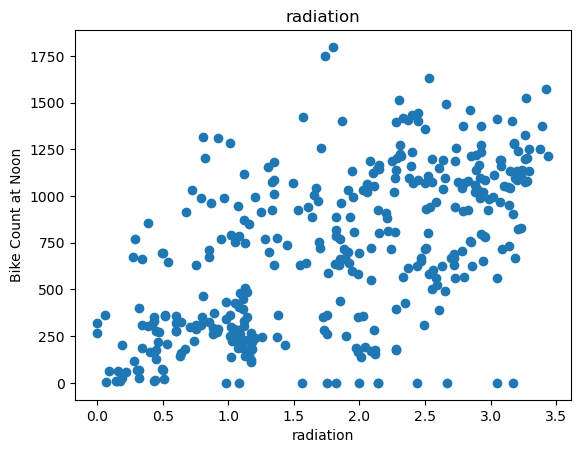

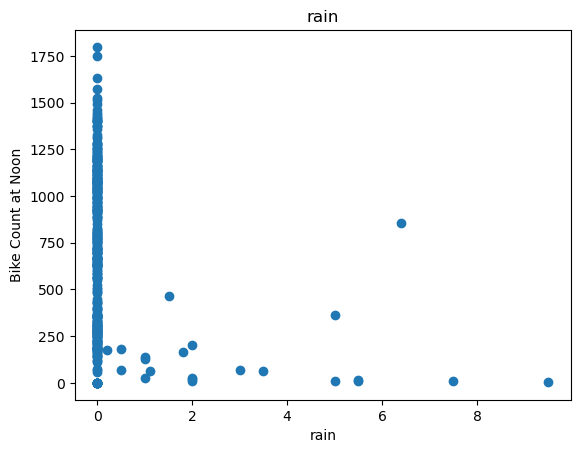

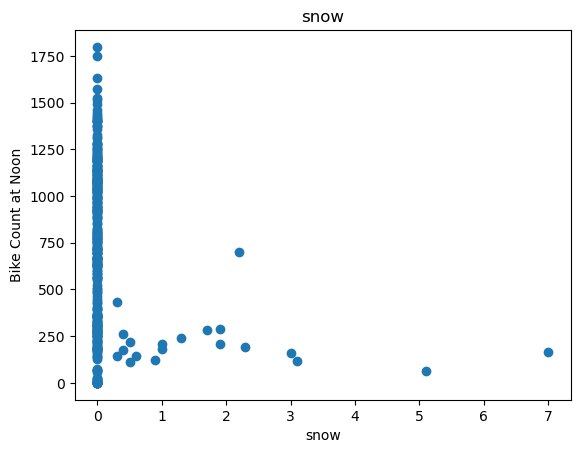

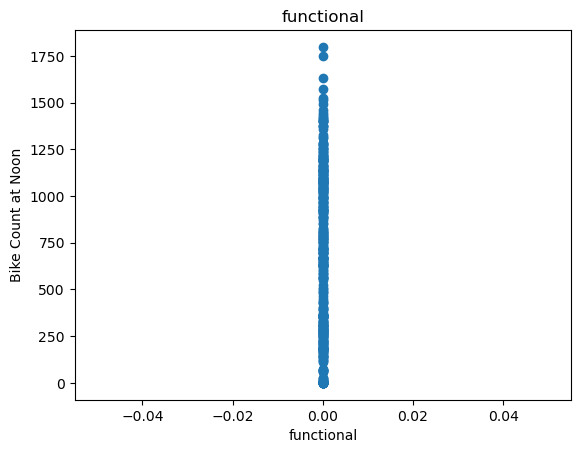

In [18]:
for label in df.columns[1:]:
    plt.scatter(df[label], df["bike_count"])
    plt.title(label)
    plt.ylabel("Bike Count at Noon")
    plt.xlabel(label)
    plt.show()

In [19]:
df = df.drop(["wind", "visibility", "functional"], axis=1)

In [20]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


### Train/Valid/Test Dataset

In [34]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [35]:
def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
    else:
        if len(x_labels) ==1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        else: 
            X = dataframe[x_labels].values
    y = dataframe[y_label].values.reshape(-1,1)
    data = np.hstack((X,y))

    return data, X, y

In [36]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [37]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)


LinearRegression()

In [38]:
print(temp_reg.coef_, temp_reg.intercept_)
temp_reg.score(X_test_temp, y_test_temp)

[[22.07471232]] [359.04880826]


0.208819043495042

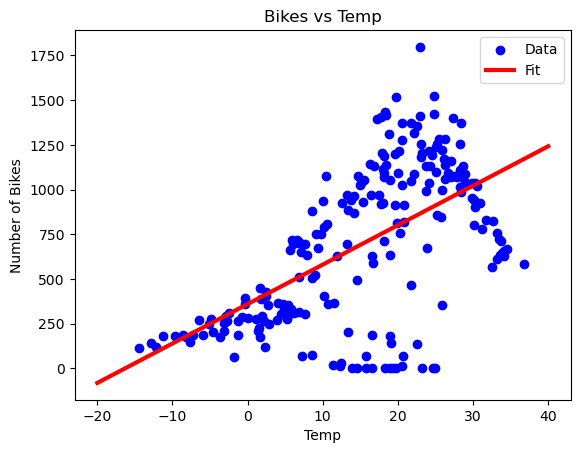

In [39]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="Blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()

### Multiple Linear Regression

In [40]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [41]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)


LinearRegression()

In [42]:
all_reg.score(X_test_all, y_test_all)

0.5148914213633192

### Regression with Neural Net

In [43]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [44]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [45]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [47]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_temp, y_val_temp)
)

In [50]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

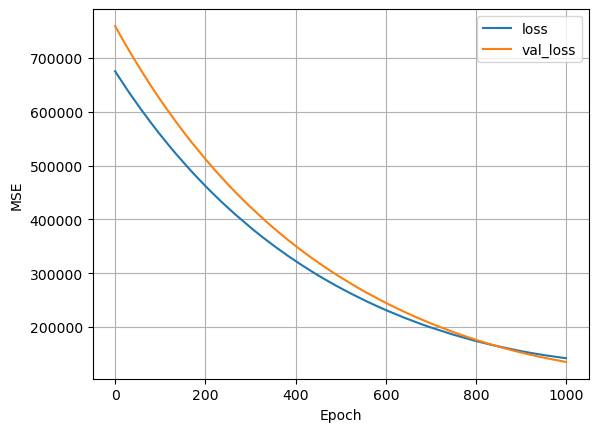

In [51]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


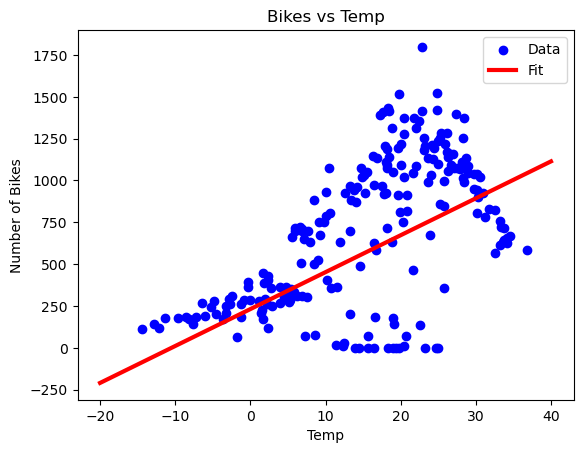

In [52]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="Blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()

## Neural Net

In [61]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation ='relu'),
    tf.keras.layers.Dense(32, activation ='relu'),
    tf.keras.layers.Dense(1, activation ='relu'),
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [62]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_val_temp, y_val_temp),
    verbose =0, epochs=100
)

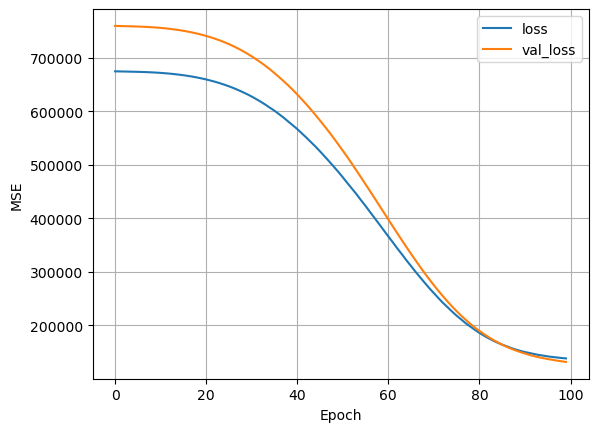

In [63]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


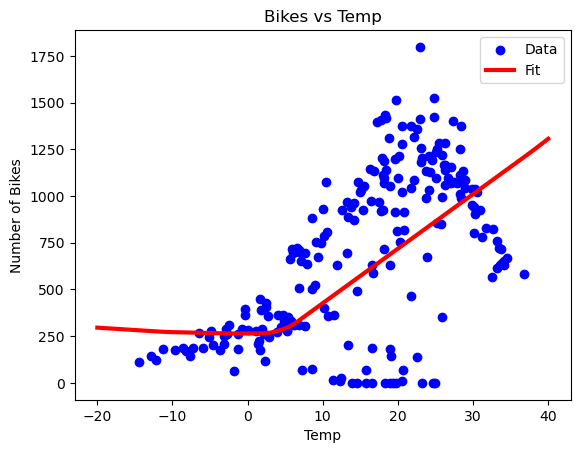

In [65]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="Blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()

# Terrible prediction, but shows that the predictions are no longer linear

In [79]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)

nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation ='relu'),
    tf.keras.layers.Dense(32, activation ='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [80]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data=(X_val_all, y_val_all),
    verbose=0, epochs=100
    )

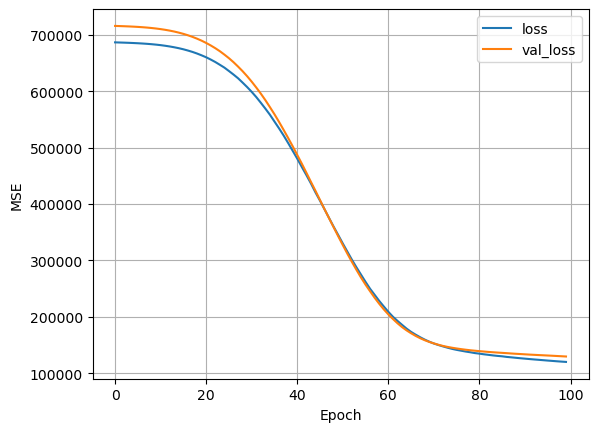

In [81]:
plot_loss(history)

In [82]:
# Calculate MSE for both linear reg and NN

y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 [==============================] - 0s 2ms/step


In [83]:
def MSE(y_pred, y_real):
    return (np.square(y_pred-y_real)).mean()


In [84]:
MSE(y_pred_lr, y_test_all)

90889.37197765458

In [85]:
MSE(y_pred_nn, y_test_all)

105044.77101742405

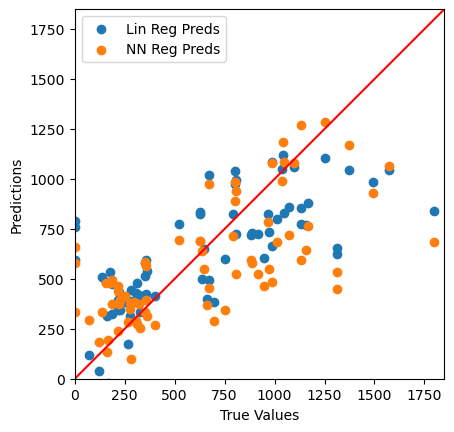

In [94]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Reg Preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1850]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")